In [20]:
import numpy as np
import pandas as pd

In [2]:
# import some dependencies
import h5py
import numpy as np
import pandas as pd
import json
import os
import socket
os.environ['KERAS_BACKEND'] = 'tensorflow'
import tensorflow as tf

In [3]:
use_gpu = True
from keras.backend.tensorflow_backend import set_session

dc =  {'GPU': 1 if use_gpu else 0, 'CPU': 1}
print('dev',dc)

config = tf.ConfigProto(device_count =  dc)
config.gpu_options.per_process_gpu_memory_fraction = 0.95
set_session(tf.Session(config=config))

dev {'GPU': 1, 'CPU': 1}


In [4]:
from keras.layers import BatchNormalization
from keras.layers import Dense, Dropout, Activation, Input, add
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, Callback, EarlyStopping
from keras.utils import np_utils

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import sys
sys.path.append("../.")
import train_tools as tt

In [7]:
model_name = "/gpfs/slac/atlas/fs1/d/mg294/DL1_training_files/DL1_models/Gluon-splitting-2dim"

In [8]:
infile = "/gpfs/slac/atlas/fs1/d/mg294/gluon_splitting/trainfile.h5"

In [9]:
df_bb = pd.read_hdf(infile, "bbjets")
df_b = pd.read_hdf(infile, "bjets")
# df_c = pd.read_hdf(infile, "cjets")
# df_u = pd.read_hdf(infile, "ujets")

In [26]:
# weightsbb = df_bb['weight'].values
# weightsbb = df_b['weight'].values
# print(df_c['weight'].sum())
# print(df_u['weight'].sum())

In [ ]:
default_dict ="/gpfs/slac/atlas/fs1/d/mg294/DL1_training_files/params_MC16D-ext_2018-PFlow_70-4M_mu.json"
with open(default_dict) as vardict:
                default_dict = json.load(vardict)
print(default_dict)

In [10]:
default_dict ="/gpfs/slac/atlas/fs1/d/mg294/DL1_training_files/params_MC16D-ext_2018-PFlow_70-4M_mu.json"
with open(default_dict) as vardict:
                default_dict = json.load(vardict)
default_dict2 = tt.Gen_default_dict(default_dict)        
df_bb.replace([np.inf, -np.inf], np.nan, inplace=True)
df_bb.fillna(default_dict2, inplace=True)
df_b.replace([np.inf, -np.inf], np.nan, inplace=True)
df_b.fillna(default_dict2, inplace=True)
# df_c.replace([np.inf, -np.inf], np.nan, inplace=True)
# df_c.fillna(default_dict, inplace=True)
# df_u.replace([np.inf, -np.inf], np.nan, inplace=True)
# df_u.fillna(default_dict, inplace=True)

In [11]:
train_vars = ["abs_eta_uncalib",
"pt_uncalib",
"JetFitter_mass",
"JetFitter_isDefaults",
"JetFitter_energyFraction",
"JetFitter_significance3d",
"JetFitter_nVTX",
"JetFitter_nSingleTracks",
"JetFitter_nTracksAtVtx",
"JetFitter_N2Tpair",
"JetFitter_deltaR",
"SV1_NGTinSvx",
"SV1_masssvx",
"SV1_isDefaults",
"SV1_N2Tpair",
"SV1_efracsvx",
"SV1_deltaR",
"SV1_Lxy",
"SV1_L3d",
"SV1_significance3d",
"IP2D_bu",
"IP2D_isDefaults",
"IP2D_bc",
"IP2D_cu",
"IP3D_bu",
"IP3D_isDefaults",
"IP3D_bc",
"IP3D_cu",
"secondaryVtx_nTrks",
"secondaryVtx_isDefaults",
"secondaryVtx_m",
"secondaryVtx_E",
"secondaryVtx_EFrac",
"secondaryVtx_L3d",
"secondaryVtx_Lxy",
"secondaryVtx_max_trk_flightDirRelEta",
"secondaryVtx_min_trk_flightDirRelEta",
"secondaryVtx_avg_trk_flightDirRelEta",
"max_trk_flightDirRelEta",
"min_trk_flightDirRelEta",
"avg_trk_flightDirRelEta",
"iprnn_pb",
"iprnn_pc",
"iprnn_pu",
"softMuon_dR",
"softMuon_qOverPratio",
"softMuon_momentumBalanceSignificance",
"softMuon_scatteringNeighbourSignificance",
"softMuon_pTrel",
"softMuon_ip3dD0",
"softMuon_ip3dZ0",
"softMuon_ip3dD0Significance",
"softMuon_ip3dZ0Significance",
"softMuon_isDefaults"
]
variablelist=train_vars

In [12]:
scale_dic = {}
for var in default_dict:
    scale_dic[var['name']] = var

In [ ]:
var = "pt_uncalib"
# (df_bb[var] - scale_dic[var]['shift'])/scale_dic[var]['scale']
df_bb[var]

In [13]:
for var in train_vars:
    df_bb[var] = (df_bb[var] - scale_dic[var]['shift'])/scale_dic[var]['scale']
    df_b[var] = (df_b[var] - scale_dic[var]['shift'])/scale_dic[var]['scale']

In [64]:
print(len(df_bb.query("SV1_masssvx == %f" % default_dict["SV1_masssvx"])))
print(len(df_bb.query("SV1_isDefaults == 1")))
print(len(df_b.query("SV1_masssvx == %f" % default_dict["SV1_masssvx"])))
print(len(df_b.query("SV1_isDefaults == 1")))

152122
152122
238923
238923


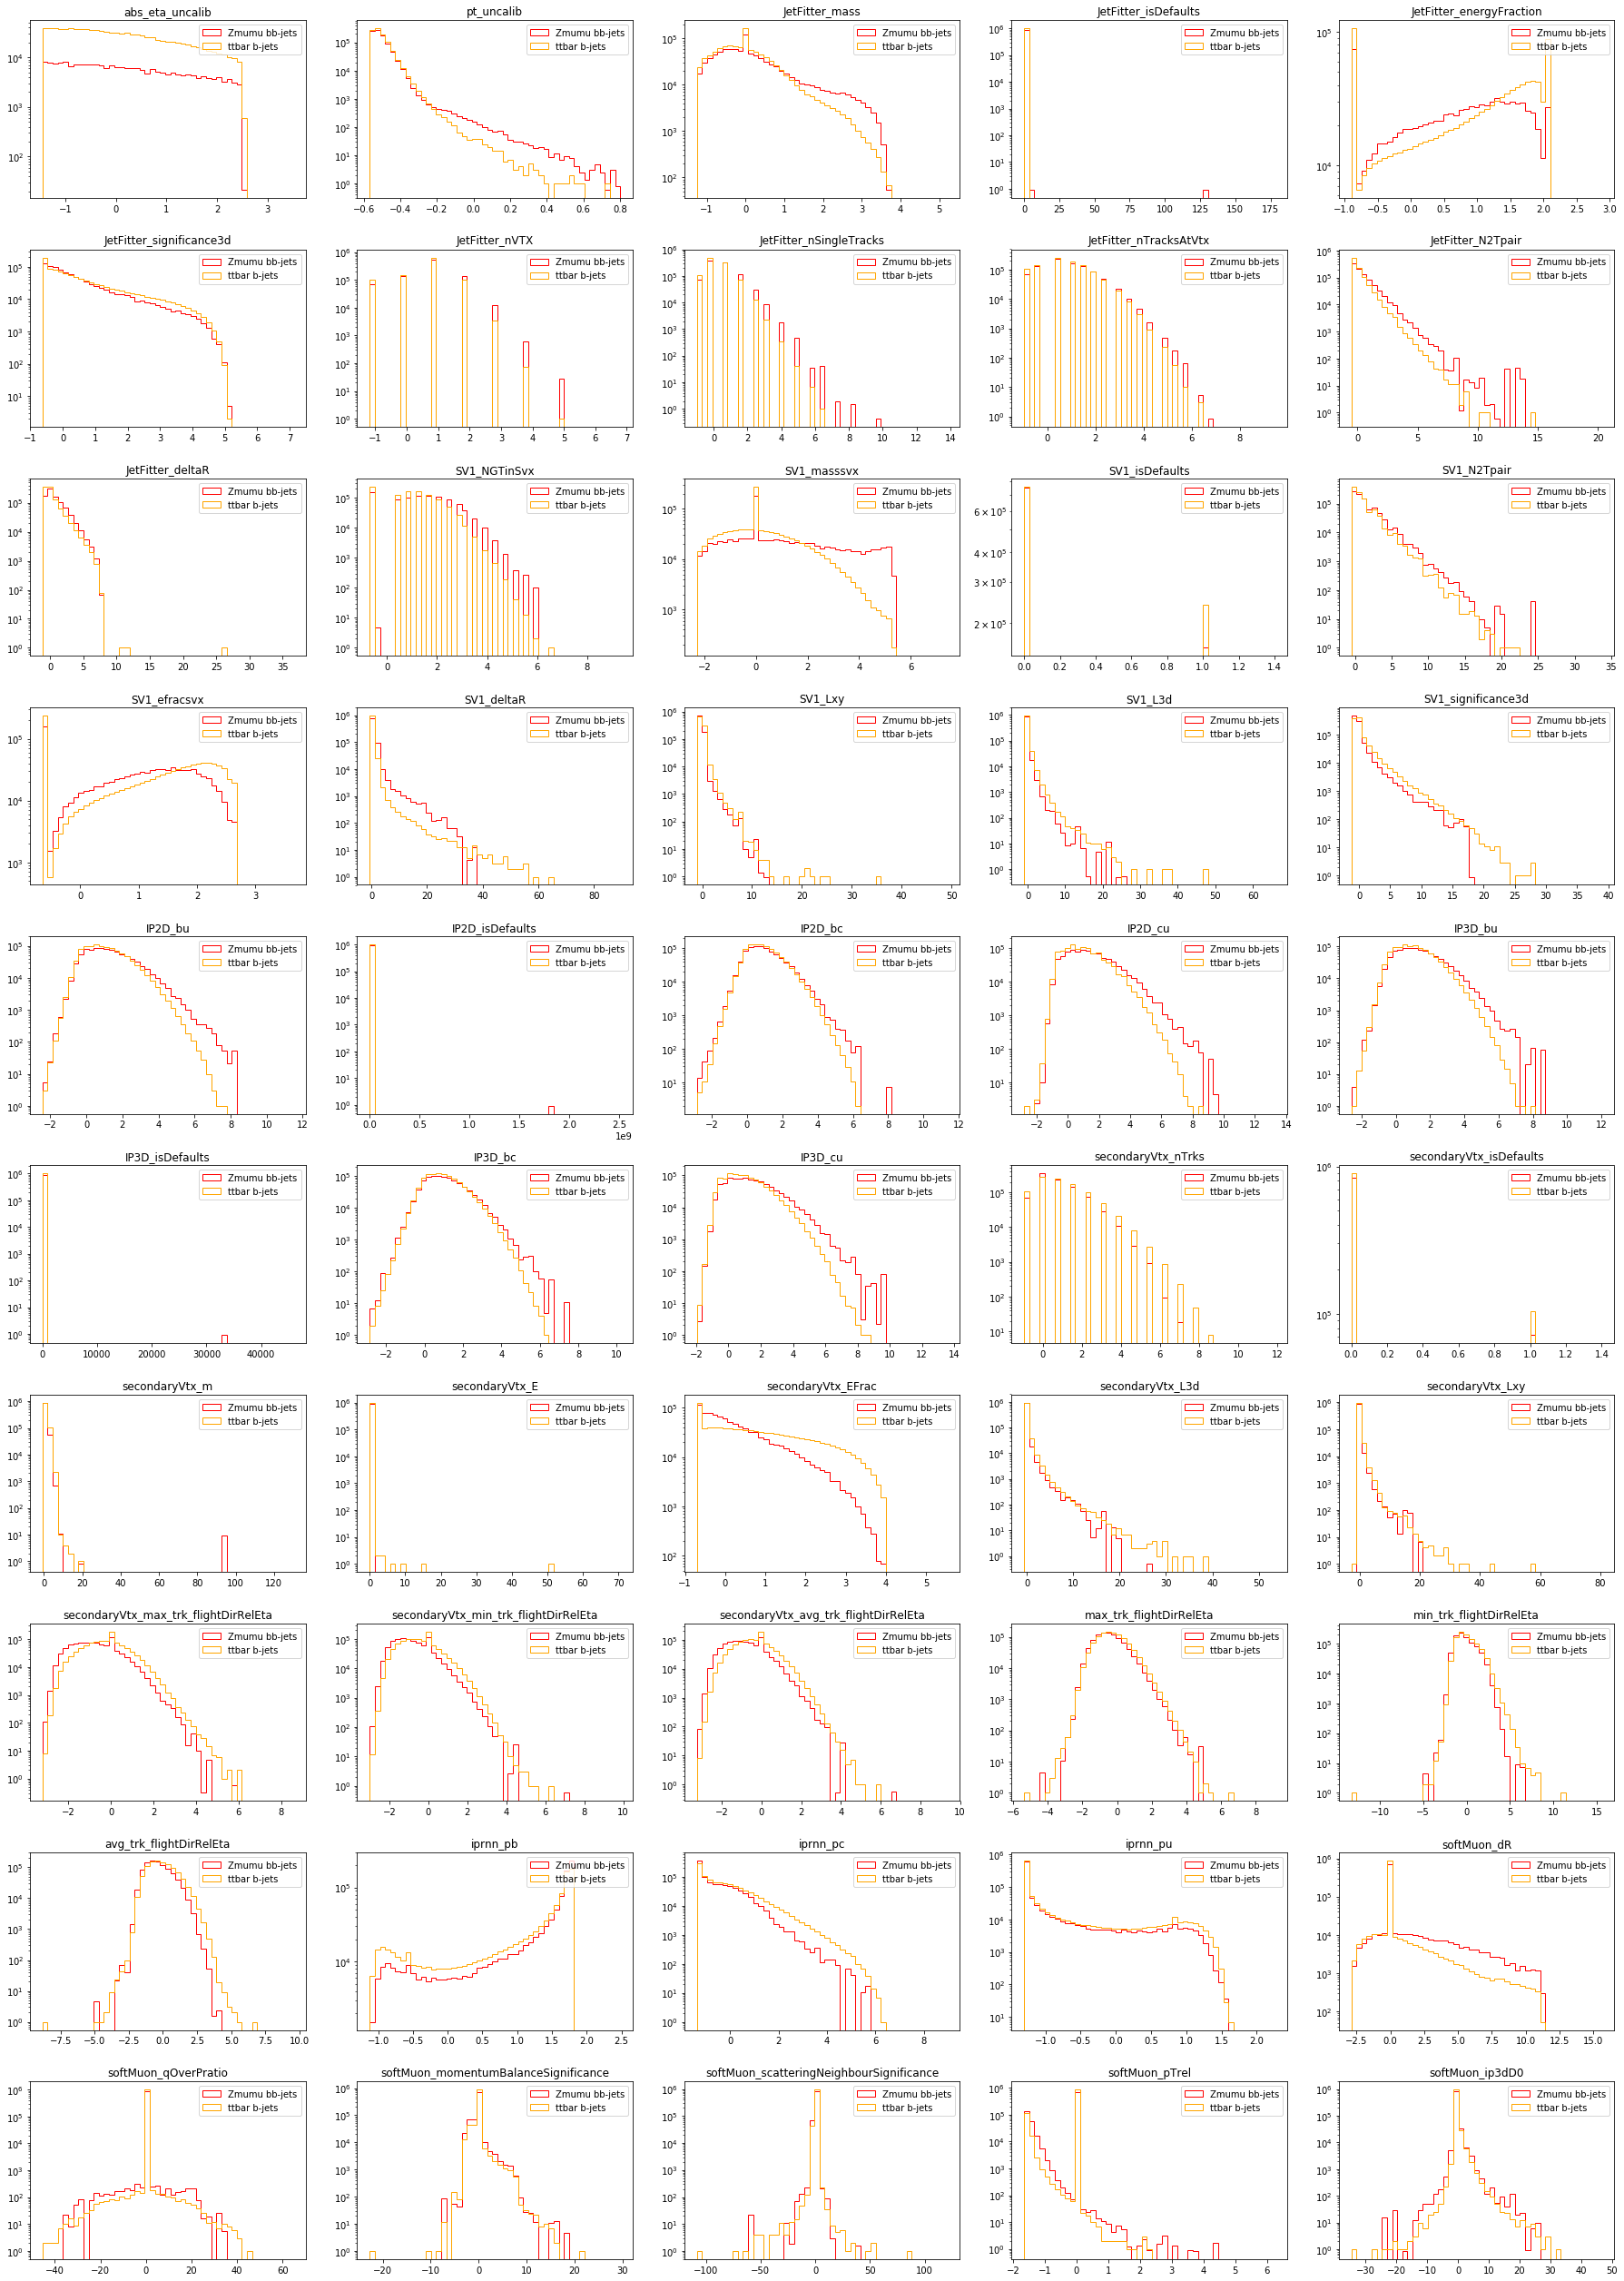

In [80]:
fig, ax = plt.subplots(10, 5, figsize=(25, 35))
nbins = 50
# nbins = 20

varcounter = -1
for i, axobjlist in enumerate(ax):
      for j, axobj in enumerate(axobjlist):
        varcounter+=1
        if varcounter < len(variablelist):
#             X = df[[variablelist[varcounter], 'HadronConeExclTruthLabelID', 'HadronConeExclExtendedTruthLabelID']]
#             X = df.query('min_trk_flightDirRelEta>5.25')[[variablelist[varcounter], 'HadronConeExclTruthLabelID']]
#             X.dropna(inplace=True)
            var = variablelist[varcounter]
            bb = df_bb[[var, "weight"]].dropna()
            b = df_b[[var, "weight"]].dropna()
#             c = df_cjets[[var, "weight"]].dropna()
#             u = df_ujets[[var, "weight"]].dropna()
            


            minval = np.amin(b[var])
            if 'pt' in var:
                maxval = np.percentile(bb[var],99.99)
            else:
                maxval = max([np.amax(b[var]), np.amax(bb[var])])*1.4
            binning = np.linspace(minval,maxval,nbins)

            axobj.hist(bb[var],binning,histtype=u'step', color='r',label='Zmumu bb-jets',density=None, weights=bb["weight"])
            axobj.hist(b[var],binning,histtype=u'step', color='orange',label='ttbar b-jets',density=None, weights=b["weight"])
#             axobj.hist(c[var],binning,histtype=u'step', color='b',label='ttbar c-jets',density=1, weights=c["weight"])
#             axobj.hist(u[var],binning,histtype=u'step', color='g',label='ttbar u-jets',density=1, weights=u["weight"])

            
            axobj.legend()
            axobj.set_yscale('log',nonposy='clip')
            axobj.set_title(variablelist[varcounter])

        else:
            axobj.axis('off')

plt.tight_layout()
#plt.savefig('mc16d_train_ttbar.pdf')
plt.savefig("Zmumu-btagVars-new.pdf", transparent=True)
plt.show()

In [14]:
train_dic = {"bbjets": df_bb.query("eventNumber %2 == 0")[train_vars],
             "bjets": df_b.query("eventNumber %2 == 0")[train_vars]}
#              ,"cjets": df_c.query("eventNumber %2 == 0")[train_vars],
#              "ujets": df_u.query("eventNumber %2 == 0")[train_vars]}
w_b = df_b.query("eventNumber %2 == 0")['weight'].values
w_bb = df_bb.query("eventNumber %2 == 0")['weight'].values

In [24]:
test_dic = {"bbjets": df_bb.query("eventNumber %2 == 1")[train_vars],
             "bjets": df_b.query("eventNumber %2 == 1")[train_vars]}#,
#              "cjets": df_c.query("eventNumber %2 == 1")[train_vars],
#              "ujets": df_u.query("eventNumber %2 == 1")[train_vars]}

In [ ]:
np.save("/gpfs/slac/atlas/fs1/d/mg294/gluon_splitting/test-bb-2dim.npy", test_dic["bbjets"].values)
np.save("/gpfs/slac/atlas/fs1/d/mg294/gluon_splitting/test-b-2dim.npy", test_dic["bjets"].values)
# np.save("/gpfs/slac/atlas/fs1/d/mg294/gluon_splitting/test-c.npy", test_dic["cjets"].values)
# np.save("/gpfs/slac/atlas/fs1/d/mg294/gluon_splitting/test-u.npy", test_dic["ujets"].values)

In [15]:
# labels = np.concatenate([np.zeros(len(train_dic['ujets'])), 
#                         np.ones(len(train_dic['cjets'])),
#                         2 * np.ones(len(train_dic['bjets'])),
#                         3 * np.ones(len(train_dic['bbjets']))])
# Y_train = np_utils.to_categorical(labels, 4)
labels = np.concatenate([np.zeros(len(train_dic['bjets'])), 
                        np.ones(len(train_dic['bbjets']))])
Y_train = np_utils.to_categorical(labels, 2)

In [16]:
# X_train = np.concatenate([train_dic['ujets'], train_dic['cjets'], train_dic['bjets'], train_dic['bbjets']])
X_train = np.concatenate([train_dic['bjets'], train_dic['bbjets']])
weights = np.concatenate([w_b, w_bb])

In [17]:
# shuffle the arrays
rng_state = np.random.get_state()
np.random.shuffle(X_train)
np.random.set_state(rng_state)
np.random.shuffle(Y_train)
np.random.set_state(rng_state)
np.random.shuffle(weights)

In [89]:
np.save("/gpfs/slac/atlas/fs1/d/mg294/gluon_splitting/X_train-2dim.npy", X_train)
np.save("/gpfs/slac/atlas/fs1/d/mg294/gluon_splitting/Y_train-2dim.npy", Y_train)

In [ ]:
X_train = np.load("/gpfs/slac/atlas/fs1/d/mg294/gluon_splitting/X_train.npy")
Y_train = np.load("/gpfs/slac/atlas/fs1/d/mg294/gluon_splitting/Y_train.npy")

In [18]:
# NN model
inputs = Input(shape=(X_train.shape[1],))
l_units = [72, 57, 60, 48, 36, 24, 12, 6]
# l_units = [72, 36, 24, 12, 6]
x = inputs
for unit in l_units:
    x = Dense(units=unit, activation="linear", kernel_initializer='glorot_uniform')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
#     x = Dropout(0.1)
predictions = Dense(units=2, activation='softmax',
                    kernel_initializer='glorot_uniform')(x)

model = Model(inputs=inputs, outputs=predictions)
# model.summary()

model_optimizer = Adam(lr=0.001)
# model_optimizer = Adam(lr=0.005)
model.compile(  # loss='mse',
    loss='categorical_crossentropy',
    optimizer=model_optimizer,
    metrics=['accuracy']
)

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
print(X_train)
# tf.keras.backend.clear_session()

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.00001)
my_callback = tt.MyCallback(test_data=X_train,
                         test_label=Y_train,
                         model_name=model_name)

# earlyStop = EarlyStopping(verbose=True, patience=30, monitor='val_loss')

callbacks = [reduce_lr, my_callback]
model.fit(X_train, Y_train, batch_size=3000, epochs=200, validation_split=0.3, callbacks=callbacks, sample_weight=weights )

In [44]:
bbjets = np.load("/gpfs/slac/atlas/fs1/d/mg294/gluon_splitting/test-bb.npy")
bjets = np.load("/gpfs/slac/atlas/fs1/d/mg294/gluon_splitting/test-b.npy")
# cjets = np.load("/gpfs/slac/atlas/fs1/d/mg294/gluon_splitting/test-c.npy")
# ujets = np.load("/gpfs/slac/atlas/fs1/d/mg294/gluon_splitting/test-u.npy")

In [25]:
bbjets = test_dic["bbjets"]
bjets = test_dic["bjets"]

In [28]:
model_file = '%s/model_epoch%i.h5' % (model_name, 199)
# rej_arr_c, rej_arr_u = tt.GetRejCurve(model_file, bjets, cjets, bbjets,
#                                       onlyRej=False, fixed_fc=True, onlyPred=True)
bs, cs, bbs = tt.GetRejCurve(model_file, bjets, cjets, bbjets,
                                      onlyRej=False, fixed_fc=True, onlyPred=True)
# np.save("numpy_output/SMT-softMuon-NN.npy",{"crej": rej_arr_c, "urej": rej_arr_u})

423308/423308 [==============================] - 1s 3us/step


In [51]:
print(len(df_bb.query("eventNumber %2 == 1")['weight']))
print(len(bbs))

423308
423308


In [26]:
from keras.models import load_model
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform
model_file = '%s/model_epoch%i.h5' % (model_name, 199)
with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
        model = load_model(model_file)
bjets_pred = model.predict(bjets, batch_size=5000, verbose=1)
bbjets_pred = model.predict(bbjets, batch_size=5000, verbose=1)

423308/423308 [==============================] - 1s 2us/step


In [ ]:
bjets_pred

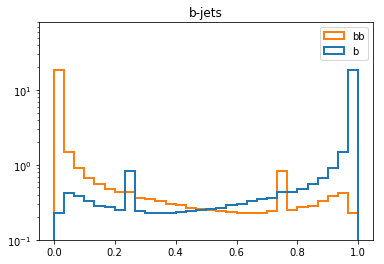

In [59]:
import matplotlib.pyplot as plt
plt.hist([bjets_pred[:,0], bjets_pred[:,1]],label=["b", "bb"], bins=30,histtype=u'step', log=True, linewidth=2, density=1)
plt.legend()
plt.ylim(1e-1, 8e1)
plt.title("b-jets")
plt.savefig("b-jets-prob.pdf", transparent=True)

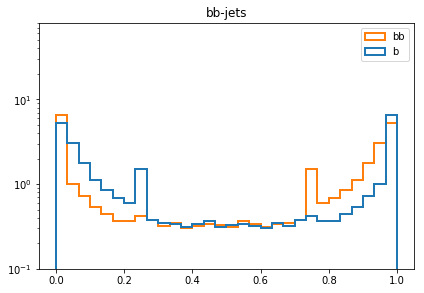

In [60]:
plt.hist([bbjets_pred[:,0], bbjets_pred[:,1]], bins=30,histtype=u'step',label=["b", "bb"], log=True, linewidth=2, density=1)
plt.legend()
plt.tight_layout()
plt.ylim(1e-1, 8e1)
plt.title("bb-jets")
# plt.set_yscale('log')
plt.savefig("bb-jets-prob.pdf", transparent=True)

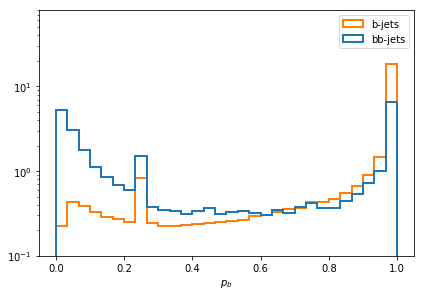

In [68]:
plt.hist([bbjets_pred[:,0], bjets_pred[:,0]], bins=30,histtype=u'step',label=["bb-jets", "b-jets"], log=True, linewidth=2, density=1)
plt.legend()
plt.tight_layout()
plt.ylim(1e-1, 8e1)
plt.xlabel(u"$p_{b}$")
# plt.title("bb-jets")
# plt.set_yscale('log')
plt.savefig("bb-tag-pb.pdf", transparent=True)

Text(18.50828125, 0.5, 'a.u.')

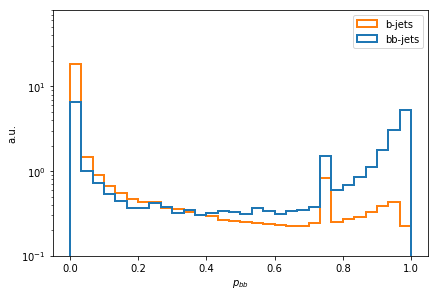

In [70]:
plt.hist([bbjets_pred[:,1], bjets_pred[:,1]], bins=30,histtype=u'step',label=["bb-jets", "b-jets"], log=True, linewidth=2, density=1)
plt.legend()
plt.tight_layout()
plt.ylim(1e-1, 8e1)
plt.xlabel("$p_{bb}$")
plt.ylabel("a.u.")
None

In [100]:
b_eff_70 = np.percentile(bjets_pred[:,0], 30)
bb_eff_30 = np.percentile(bbjets_pred[:,1], 70)

In [92]:
print(len(np.where(bjets_pred[:,0]>b_eff_70)[0]))
print(len(np.where(bjets_pred[:,0]<b_eff_70)[0]))
print(len(np.where(bbjets_pred[:,0]>b_eff_70)[0]))
# print((bjets_pred[:,0]>np.percentile(bjets_pred, 30)))
# print(len(bjets_pred<np.percentile(bjets_pred, 70)))

350007
150003
122597


In [102]:
print(len(np.where(bjets_pred[:,1]>bb_eff_30)[0]))
print(len(np.where(bjets_pred[:,1]<bb_eff_30)[0]))

13227
486783


In [103]:
print((13227/len(bjets)))
print(1/(13227/len(bjets)))

0.02645347093058139
37.80222272624178


In [104]:
bb_eff_30 = np.percentile(bbjets_pred[:,1], 70)
left_bs = len(np.where(bjets_pred[:,1]>bb_eff_30)[0])
print(1/(left_bs/len(bjets)))

37.80222272624178


In [96]:
print((122597/len(bbjets)))
print(1/(122597/len(bbjets)))

0.2896165439821596
3.452841423525861


Text(0.5, 1.0, 'bjets')

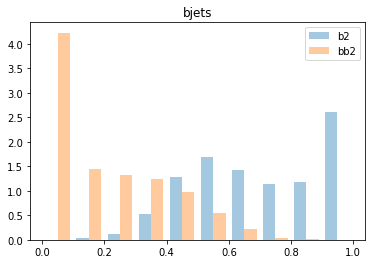

In [55]:
import matplotlib.pyplot as plt
# plt.hist([bs[:,2], bs[:,3]], label=["b", "bb"], density=1, alpha=0.4)
plt.hist([bbs[:,2], bbs[:,3]], label=["b2", "bb2"], density=1, alpha=0.4, weights=[df_bb.query("eventNumber %2 == 1")['weight'].values, df_bb.query("eventNumber %2 == 1")['weight'].values])
plt.legend()
plt.title("bjets")

Text(0.5, 1.0, 'bbjets')

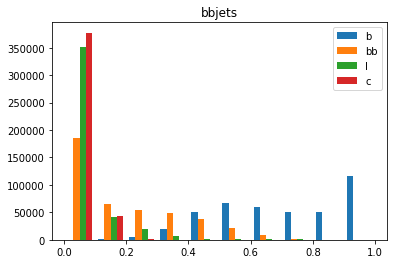

In [48]:
plt.hist([bbs[:,2], bbs[:,3], bbs[:,0] , bbs[:,1]], label=["b", "bb", "l", "c"])
plt.legend()
plt.title("bbjets")

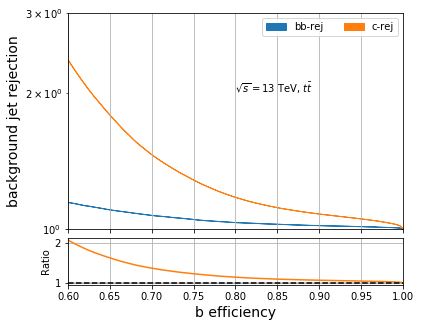

In [20]:
b_effs = np.linspace(0.59, 1, 100)
tt.plotROCRatio([b_effs, b_effs] , [1./rej_arr_u, 1./rej_arr_c], ['bb-rej', 'c-rej'], ymax=3e0,
                ylabel='background jet rejection', binomialErrors=True, nTest=1.5e6,
#                 plot_name="pots/PFlow_u-rej_beff-softM-SMT.pdf",
                alabel={"x": 0.8, "y": 2e0, "s":r"$\sqrt{s}=13$ TeV, $t\bar{t}$"},
               plot_name="double-b.pdf")
                
#                 text='DL1r with softMuon and SMT')